# 04A. Delayed differential equations

### Mingyang Lu

### 2/12/2024

# Intro

Many dynamical systems involve processes with time delays. Such a time-delay system can be described by rate equations containing functions of previous time points. This type of differential equations is called delay differential equations (DDEs). 

We consider again the exponential growth model, but now the rate equation depends on $N$ an earlier time point $t - \tau$:

$$\frac{dN}{dt} = r N(t-\tau) \tag {1}$$

Here, $N$ is the population size, $t$ is time, $\tau$ is a constant time delay. We consider $\tau = 1$ here. Unlike ODEs where an initial condition (*i.e.*, $N(t_0)$ here) needs to be specified, the DDE in Equation (1) requires $N(t)$ for $t \in [t_0-\tau, t_0]$. If a time-delay system has an steady state $N_s$, $N_s$ is also the steady state of the corresponding ODE with time delays. (This is because a steady state is time independent) Thus, same method for ODEs can be used to identify steady state solutions. However, the stability of the system may change because of time delays.

# Euler method for DDE

We consider the DDE in Equation (1) and $N(t - \tau) = N_0$ for $t \leq \tau$. (Be careful, this seems intuitive but may cause issues as the derivatives of the solutions are discontinuous. Because of the discontinuity of the time trajectories, DDE often is ill defined. One needs to be cautious when interpreting the simulation results of DDE.) The most common way to simulate a DDE is to generate time steps and $N$ solutions for the whole interval $t \in [-\tau, t_{max}]$. $N(t-\tau)$ can be retrieve anytime during DDE integration. This is not the most efficient numerical method, due to high storage requirement for saving the whole trajectory (Q: think how to make it more efficient, see the section **Method of steps**).

The function *dN_delays* specifies the derivative function for a system with a constant time delay. Note that we supply $N$ for both current time *N* and previous time *N_old*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# derivative function for delay exponential growth model
# t: time
# N: population size of the current time N(t)
# N_old: population size of the previous time N(t-tau). 
#        We will use the DDE integrator to specify the constant time delay.
# r: parameter, growth rate
def dN_delays(t, N, N_old, r):
   return r*N_old

The DDE integrator can be modified from an ODE integrator to incorporate data from previous time points. Below, we present an implementation using the Euler method.

$$N_{n+1} = N_n + h*f(t_n, N_n, N_{n-d}) \tag {2}$$

Here, $n - d$ represents the index of the time step for delays. 

In [2]:
def dde_euler(derivs, t0, X0, t_total, dt, tau, **kwargs):
    """
    Euler method for DDEs with a constant time delay.

    Parameters:
    - derivs: The function of the derivatives.
    - t0: Initial time.
    - X0: Initial condition.
    - t_total: Total simulation time.
    - dt: Time step size.
    - tau: A constant time delay.
    - **kwargs: Additional arguments for the derivative function.

    Returns:
    - Matrix of time points and corresponding solutions for all time steps.

    Note:
    - This illustrate will not work for cases using multiple time delays.
    """

    # Save data for all previous time points
    t_all = np.arange(t0 - tau, t_total + dt, step=dt)
    n_all = len(t_all)
    X_all = np.zeros(n_all)

    # Number of delay time steps
    n_delay = int(tau / dt)

    # Constant initial condition between t in [-tau, t_total]
    X_all[0:n_delay + 1] = X0

    # Euler integration loop
    for i in range(n_delay, n_all - 1):
        X_all[i+1] = X_all[i] + dt * derivs(t_all[i], X_all[i], X_all[i-n_delay], **kwargs)

    # Return a matrix of t & N(t) for all time steps
    return np.column_stack((t_all, X_all))

We set $r = -0.3$. It's a typical exponential decay. 

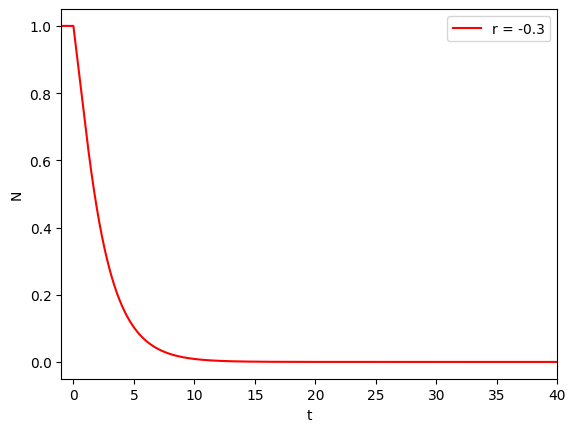

In [3]:
r1 = -0.3

results_1 = dde_euler(derivs=dN_delays, t0=0, X0=1, t_total=40, dt=0.01, tau=1, r=r1)

plt.plot(results_1[:,0], results_1[:,1], color='red')
plt.xlabel('t')
plt.ylabel('N')
plt.xlim(-1, 40)
plt.ylim(-0.05, 1.05)
plt.legend(['r = -0.3'], loc='upper right')
plt.show()

When $r$ is slightly larger than a critical point $\pi/2$, the system exhibits a damping oscillation. Note that $N$ would be negative in this model, which is unrealistic to represent the population size.

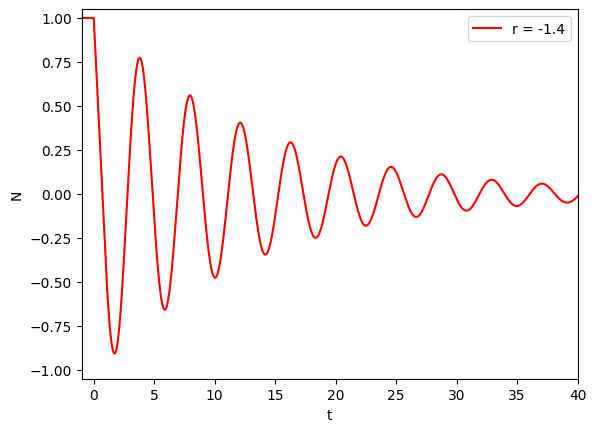

In [4]:
r2 = -1.4

results_2 = dde_euler(derivs=dN_delays, t0=0, X0=1, t_total=40, dt=0.01, tau=1, r=r2)

plt.plot(results_2[:,0], results_2[:,1], color='red')
plt.xlabel('t')
plt.ylabel('N')
plt.xlim(-1, 40)
plt.ylim(-1.05, 1.05)
plt.legend(['r = -1.4'], loc='upper right')
plt.show()

When $r$ is slightly smaller than a critical point $\pi/2$, the system exhibits an increasing oscillation.

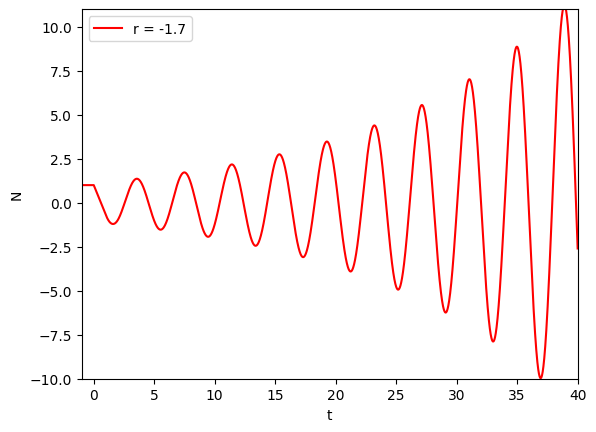

In [5]:
r3 = -1.7

results_3 = dde_euler(derivs=dN_delays, t0=0, X0=1, t_total=40, dt=0.01, tau=1, r=r3)

plt.plot(results_3[:,0], results_3[:,1], color='red')
plt.xlabel('t')
plt.ylabel('N')
plt.xlim(-1, 40)
plt.ylim(-10, 11)
plt.legend(['r = -1.7'], loc='upper left')
plt.show()

# A 2nd order DDE integrator (Heun's method)

For a better performance, we convert a second order ODE integrator, **the Heun's method**, for modeling DDE. The Heun's method is very similar to 2nd order Runge-Kutta but uses only integer time steps. So it's much convenient to convert the ODE integrator to the DDE version using Heun's method.

\begin{equation}
\begin{aligned}
k_1 &= h*f(t_n, N_n, N_{n-d}) \\
N_{n+1} &= N_n + k_1 \\
k_2 &= h*f(t_{n+1}, N_{n+1}, N_{n+1-d}) \\
N_{n+1} &= N_n + (k_1+k_2)/2
\end{aligned}\tag{3}
\end{equation}


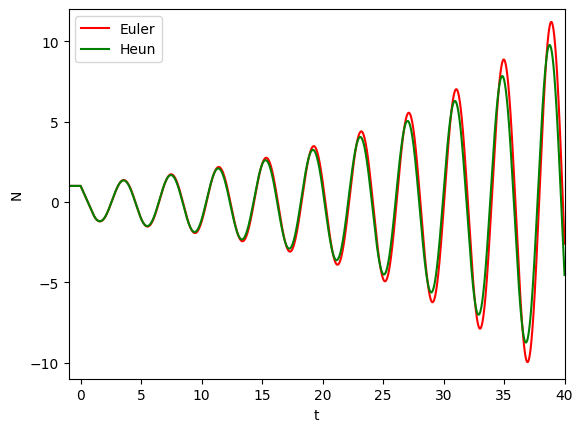

In [6]:
# Function to perform Heun's method for DDEs with a constant time delay
def dde_heun(derivs, t0, X0, t_total, dt, tau, **kwargs):
    """
    Heun's method for DDEs with a constant time delay.

    Parameters:
    - derivs: The function of the derivatives.
    - t0: Initial time.
    - X0: Initial condition.
    - t_total: Total simulation time.
    - dt: Time step size.
    - tau: A constant time delay.
    - **kwargs: Additional keyword arguments for the derivative function.

    Returns:
    - Matrix of time points and corresponding solutions for all time steps.
    """

    # Save data for all previous time points
    t_all = np.arange(t0 - tau, t_total + dt, step=dt)
    n_all = len(t_all)
    X_all = np.zeros(n_all)

    # Number of delay time steps
    n_delay = int(tau / dt)

    # Constant initial condition between t in [-tau, 0]
    X_all[0:n_delay + 1] = X0

    # Heun's method integration loop
    for i in range(n_delay, n_all - 1):
        k1 = dt * derivs(t_all[i], X_all[i], X_all[i-n_delay], **kwargs)
        X_all[i+1] = X_all[i] + k1
        k2 = dt * derivs(t_all[i + 1], X_all[i+1], X_all[i+1-n_delay], **kwargs)
        X_all[i+1] = X_all[i] + (k1 + k2) / 2

    # Return a matrix of t & N(t) for all time steps
    return np.column_stack((t_all, X_all))

# Perform Heun's method integration
results_3_2 = dde_heun(derivs=dN_delays, t0=0, X0=1, t_total=40, dt=0.01, tau=1, r=r3)

# Plot the results
plt.plot(results_3[:,0], results_3[:,1], color='red')
plt.plot(results_3_2[:,0], results_3_2[:,1], color='green')
plt.xlabel('t')
plt.ylabel('N')
plt.xlim(-1, 40)
plt.ylim(-11, 12)
plt.legend(['Euler', 'Heun'], loc='upper left')
plt.show()

The time trajectories from the two methods become more different in later time points, with the Euler trajectory slightly overshooting.